In [1]:
import glob
import json
import os
from urllib.request import urlretrieve
from multiprocessing import Pool
from collections import defaultdict, namedtuple
from pprint import pprint
import tqdm

In [159]:
SUPPORTED_TYPES = ['photo', 'audio']
DUMP_DIR = 'dumps/nikkorobk/'
DTask = namedtuple('DTask',['url', 'type', 'user_id', 'size'])
# experimental coeficients
AUDIO_SIZE_COEF = 28624
IMG_SIZE_COEF = 0.22663429
BYTE_IN_MB = 1000000

In [160]:
def make_photo_task(photo_at):
    ph = photo_at['photo']['sizes'][-1]
    url = ph['url']
    size = int(ph['width'] * ph['height'] * IMG_SIZE_COEF/ BYTE_IN_MB)
    return(DTask(url, 'photo', None, size))

def make_audio_task(audio_at):
    url= audio_at['audio']['url'].split('?')[0]
    size= int(audio_at['audio']['duration'] * AUDIO_SIZE_COEF/BYTE_IN_MB)
    return(DTask(url, 'audio', None, size))


In [161]:

def make_task(at):
    att = at['type']

    if att in SUPPORTED_TYPES:

        if att == 'photo':
            return make_photo_task(at)
        if att == 'audio':
            return make_audio_task(at)
        return ''

In [162]:

def get_download_tasks(dump_dir):
    tasks = []
    files_list=glob.glob(os.path.join(dump_dir, '*/*.json'))
    for file in tqdm.tqdm_notebook(files_list):
        user_urls = defaultdict(list)
        user_id =(os.path.basename(os.path.dirname(file)))
        conv = json.load(open(file))
        for msg in conv['items']:
            for at in msg['attachments']:
                att = at['type']
                task = make_task(at)
                if task and task.url:
                    task = task._replace(user_id=user_id) 
                    tasks.append(task)
    return tasks


In [163]:
tasks = get_download_tasks(DUMP_DIR)

In [164]:
def process_task(task):
    path_to_save =  os.path.join(DUMP_DIR, task.user_id, task.type)
    filename = task.url.split('/')[-1]
    full_name = os.path.join(path_to_save, filename)
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)
    if not os.path.exists(full_name):
        urlretrieve(task.url, full_name)
    return task.size

In [165]:
def process_tasks(tasks):
    sum_size = sum(map(lambda x: x.size, tasks))
    with Pool(processes=8) as p:
        with tqdm.tqdm_notebook(total = sum_size) as td:
            for r in p.imap_unordered(process_task, tasks):
                td.update(r)


In [167]:
process_tasks(tasks)

In [151]:
file=glob.glob(os.path.join(DUMP_DIR, '*/*.json'))[0]
(os.path.basename(os.path.dirname(file)))

'11477234'

In [84]:
audio_tasks = list(filter(lambda x: x.type == 'audio', tasks))
img_tasks = list(filter(lambda x: x.type == 'photo', tasks))

In [116]:
tasks[0]

DTask(url='https://pp.userapi.com/c849124/v849124216/374d7/pc3RDNrrfcw.jpg', type='photo', user_id='messages', size=188469.075564)

In [29]:
len(list(audio_tasks))

1129

In [30]:
audio_urls = list(map(itemgetter('url'), audio_tasks))

len(audio_urls), len(set(audio_urls))


TypeError: tuple indices must be integers or slices, not str

In [168]:
os.path.exists('dumps/nikkorobk/100/messages.json')

True

In [56]:
import requests
from operator import itemgetter
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [94]:
ds = []
ls = []
for t in tqdm.tqdm_notebook(img_tasks[:500]):
    response = requests.head(t.url)
    if response.status_code == 200:
        l = response.headers['Content-Length']
        ds.append(t.size)
        ls.append(l)
        
        

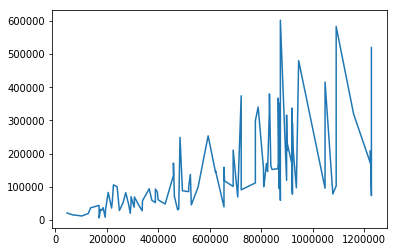

In [96]:
ls = map(int, ls)
ds, ls = zip(*sorted(zip(ds, ls)))

plt.plot(ds[:-10], ls[:-10])
plt.show()

In [97]:
ks = []
for d, l in zip(ds[:-10], ls[:-10]):
    ks.append(l/(d))
    
np.mean(ks)


0.21663429565906178

In [91]:
len(ls)

117

In [22]:
response = requests.get(audio_tasks[0].url)
l = response.headers
response.status_code, l

(404,
 {'Server': 'Internet Information Services', 'Date': 'Wed, 26 Dec 2018 14:53:58 GMT', 'Content-Type': 'text/html', 'Content-Length': '408', 'Connection': 'keep-alive', 'ETag': '"5b11df7f-198"', 'X-Frontend': 'front220022', 'Access-Control-Expose-Headers': 'X-Frontend'})

In [19]:
audio_tasks[0].url

'https://psv4.vkuseraudio.net/c5884/u3997453/audios/5112baa63114.mp3'